# Generate Data Function

In [15]:
import random
import matplotlib.pyplot as plt

def generateData(machines=4, jobs=7, seed=0):
    PROC = [ [ 0 for m in range(machines) ] for j in range(jobs) ]
    random.seed(seed)
    for j in range(jobs):
        for m in range(machines):
            PROC[j][m] = random.randint(1,9)
    return PROC
PROC = generateData(machines=4, jobs=7, seed=9525)
print(PROC)

[[3, 5, 5, 6], [4, 8, 5, 4], [9, 4, 6, 4], [6, 5, 9, 2], [7, 9, 2, 4], [8, 8, 3, 4], [8, 2, 8, 9]]


# IP Implementation - From Class

In [2]:
import pulp

def IP(PROC):

    steps = [ len(job) for job in PROC ]
    assert(min(steps)==max(steps))
    N_MACHINES = len(PROC[0])
    N_JOBS = len(PROC)


    def val(x):
        return int(pulp.value(x))

    def proc(job, machine):
        return pulp.lpSum( [ PROC[j][machine] * JJ[job][j] for j in range(N_JOBS) ] ) 

    JJ = pulp.LpVariable.dicts("J", (range(N_JOBS), range(N_JOBS)), lowBound=0, upBound=1, cat='Integer')
    Wait = pulp.LpVariable.dicts("WAIT", (range(N_JOBS), range(N_MACHINES)), lowBound=0, cat='Integer')
    Idle = pulp.LpVariable.dicts("IDLE", (range(N_JOBS), range(N_MACHINES)), lowBound=0, cat='Integer')
    Start = pulp.LpVariable.dicts("START", (range(N_JOBS), range(N_MACHINES)), lowBound=0, cat='Integer')
    Stop = pulp.LpVariable.dicts("STOP", (range(N_JOBS), range(N_MACHINES)), lowBound=0, cat='Integer')

    prob = pulp.LpProblem("JobScheduling",pulp.LpMinimize)
    prob += Stop[N_JOBS-1][N_MACHINES-1]

    # JJ is a permutation of the jobs
    for j in range(N_JOBS):
        prob += pulp.lpSum( [ JJ[j][jj] for jj in range(N_JOBS) ] ) == 1
        prob += pulp.lpSum( [ JJ[jj][j] for jj in range(N_JOBS) ] ) == 1

    for m in range(N_MACHINES):
        for j in range(N_JOBS):
            prob += pulp.lpSum( [ Idle[ji][m] + proc(ji, m) for ji in range(j) ] ) + Idle[j][m] == Start[j][m]

    for m in range(N_MACHINES):
        for j in range(N_JOBS):
            prob += pulp.lpSum( [ Wait[j][mi] + proc(j, mi) for mi in range(m) ] ) + Wait[j][m] == Start[j][m]

    for j in range(N_JOBS):
        for m in range(N_MACHINES):
            prob += Start[j][m] + proc(j,m) == Stop[j][m]

    solvers = pulp.listSolvers(onlyAvailable=True) 
    solver = pulp.getSolver(solvers[0], msg=0)
    prob.solve(solver)

    acc = []
    for j in range(N_JOBS):
        for jj in range(N_JOBS):
            if pulp.value(JJ[j][jj])==1:
                acc.append(jj)
                
    return acc, int(pulp.value(prob.objective))                                                 

# Greedy Implenetation

Greedy algorithm looks to take the shortest job, which is the locally optimal solution, at each stage.

In [36]:
import pandas as pd

df = pd.DataFrame(PROC)

# Add Column which is the sum of time for each Job
df.loc[:,'Job Sum'] = df.sum(axis=1)

In [37]:

df = df.sort_values(by='Job Sum',ascending=True)


Prep output for dataframe to Latex - Table 

In [39]:
df.columns = ['Machine 1','Machine 2','Machine 3','Machine 4','Total Job Time']
print(df)
df.to_latex('output_tables/greedy_example.tex')

   Machine 1  Machine 2  Machine 3  Machine 4  Total Job Time
0          3          5          5          6              19
1          4          8          5          4              21
3          6          5          9          2              22
4          7          9          2          4              22
2          9          4          6          4              23
5          8          8          3          4              23
6          8          2          8          9              27


In [5]:
order = df.index.copy()
job_order = order.values
print(job_order)

[0 1 3 4 2 5 6]


In [6]:
import numpy as np

def totalTime(PROC, seq, log=False):
    
    def isPermutation(seq):
        for i in range(len(seq)):
            if i not in seq:
                return False
        return True
    
    steps = [ len(job) for job in PROC ]
    assert(len(PROC) == len(seq))
    assert(isPermutation(seq))
    assert(min(steps)==max(steps))
    n_machines = len(PROC[0])
    n_jobs = len(PROC)
    wait = np.zeros([n_jobs, n_machines], dtype=int)
    idle = np.zeros([n_jobs, n_machines], dtype=int)
    start = np.zeros([n_jobs, n_machines], dtype=int)
    stop  = np.zeros([n_jobs, n_machines], dtype=int)
    proc = np.zeros([n_jobs, n_machines], dtype=int)
    for job in range(n_jobs):
        proc[job] = PROC[seq[job]]
    for job in range(n_jobs):
        for machine in range(n_machines):
            start[job, machine] = max(stop[job-1, machine] if job>0 else 0, stop[job, machine-1] if machine>0 else 0)
            wait[job, machine] = start[job, machine] - (stop[job, machine-1] if machine>0 else 0)
            idle[job, machine] = start[job, machine] - (stop[job-1, machine] if job>0 else 0)
            stop[job, machine] = start[job, machine] + proc[job, machine]

    if log:

        row = '|---------|'
        for m in range(n_machines):
            row += f"------------|" \
                    f"------------|"
        print(row)
        
        row = '|         |'
        for m in range(n_machines):
            row += f"            |" \
                    f" Machine: {m:1d} |"
        print(row)
        
        for j in range(n_jobs):
            
            row = '|---------|'
            for m in range(n_machines):
                row += f"------------|" \
                       f"------------|"
            print(row)
            
            row = '|         |'
            for m in range(n_machines):
                row += f"       {' ':4s} | " \
                       f"Idle: {idle[j,m]:4d} |"
            print(row)
            
            row = '|---------|'
            for m in range(n_machines):
                row += f"------------|" \
                       f"------------|"
            print(row)
            
            row = '|         |'
            for m in range(n_machines):
                row += f"       {' ':4s} | " \
                       f"Start:{start[j,m]:4d} |"  
            print(row)
            
            row = f'| Job: {seq[j]:2d} |'
            for m in range(n_machines):
                row += f" Wait: {wait[j,m]:4d} | " \
                       f"Proc: {proc[j,m]:4d} |"
            print(row)
            
            row = '|         |'
            for m in range(n_machines):
                row += f"       {' ':4s} | " \
                       f"Stop: {stop[j,m]:4d} |"  
            print(row)
            
        row = '|---------|'
        for m in range(n_machines):
            row += f"------------|" \
                    f"------------|"
        print(row)

    
    return stop[n_jobs-1, n_machines-1]                                                       

In [7]:
totalTime(PROC, job_order,log=True)

|---------|------------|------------|------------|------------|------------|------------|------------|------------|
|         |            | Machine: 0 |            | Machine: 1 |            | Machine: 2 |            | Machine: 3 |
|---------|------------|------------|------------|------------|------------|------------|------------|------------|
|         |            | Idle:    0 |            | Idle:    3 |            | Idle:    8 |            | Idle:   13 |
|---------|------------|------------|------------|------------|------------|------------|------------|------------|
|         |            | Start:   0 |            | Start:   3 |            | Start:   8 |            | Start:  13 |
| Job:  0 | Wait:    0 | Proc:    3 | Wait:    0 | Proc:    5 | Wait:    0 | Proc:    5 | Wait:    0 | Proc:    6 |
|         |            | Stop:    3 |            | Stop:    8 |            | Stop:   13 |            | Stop:   19 |
|---------|------------|------------|------------|------------|---------

65

# Comparing Greedy to Optimal Solution

Generate Code that stores values for Greedy and for Optimal in a pandas dataframe for a given number of jobs (1 - 10)

In [8]:

def generate_greedy(PROC):
    df = pd.DataFrame(PROC)
    # Add Column which is the sum of time for each Job
    df.loc[:,'Job Sum'] = df.sum(axis=1)
    df = df.sort_values(by='Job Sum',ascending=True)
    order = df.index.copy()
    job_order = order.values
    return job_order

Generate a dataframe which stores the Greedy, IP solution and job count. Used for graphing purposes too.

Possible to 

In [9]:
comparison_df = pd.DataFrame(columns=("Job Count","Greedy Time","IP Time"))

for i in range(1,50):
    PROC = generateData(machines=4, jobs=i, seed=9525)    
    job_order_greedy = generate_greedy(PROC)
    greedy_time = totalTime(PROC, job_order_greedy)
    seq, proctime = IP(PROC)
    ip_time = totalTime(PROC, seq)
    if (greedy_time<ip_time):
        raise(ValueError("Greedy Time Less Than IP Time"))
    comparison_df.loc[len(comparison_df.index)] = [i, greedy_time, ip_time] 


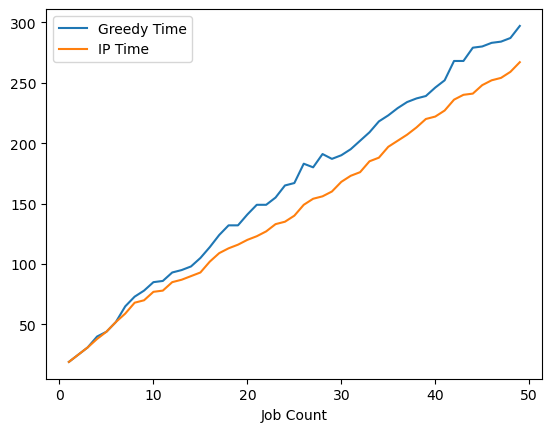

In [16]:
comparison_df.plot.line(x='Job Count',y=['Greedy Time','IP Time'])
plt.savefig('output_figures/Greedy_comparison_totals.png')

Add Delta value - i.e. Greedy time - IP Time

In [17]:
comparison_df.loc[:,'Delta'] = comparison_df['Greedy Time'] - comparison_df['IP Time']

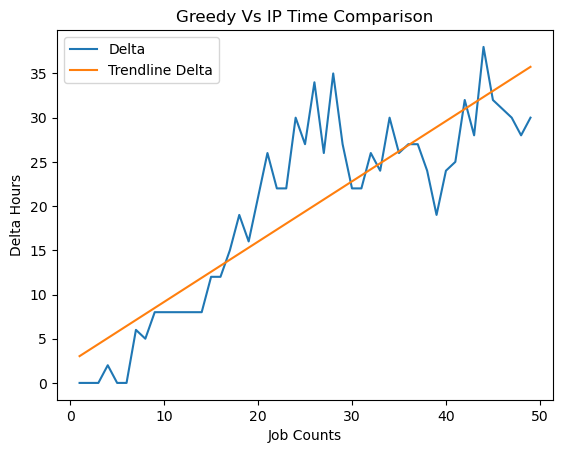

In [20]:
# Add in Trendline for Graphing purposes
polyfit_values = np.polyfit(x = comparison_df['Job Count'],y = comparison_df['Delta'],deg =1)
points = np.poly1d(polyfit_values)
comparison_df.loc[:,'Trendline Delta'] = points(comparison_df.loc[:,'Job Count'])

# Plot graph of time delta and include the line of best fit to show slope
comparison_df.plot.line(x='Job Count',y=['Delta','Trendline Delta'],ylabel = 'Delta Hours',xlabel = 'Job Counts',title = "Greedy Vs IP Time Comparison")
plt.savefig('output_figures/Greedy_comp_delta.png')

In [21]:
comparison_df.to_excel("output_excels/Greedy_Comparison.xlsx")

## Extrapolate results for 1000 jobs

To highlight the estimated* delta to the LP solution, we will extrapolate these results using line of best fit.

Job Counts         999.000000
Estimated Delta    683.297959
Name: 999, dtype: float64

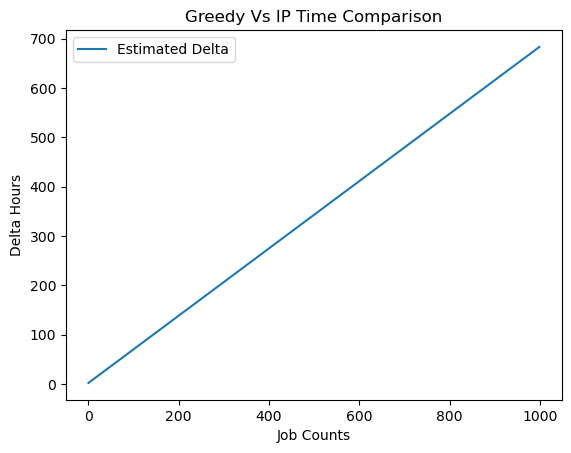

In [30]:
extrapolate = pd.DataFrame()#(columns = ['Job Counts','Estimated Delta'])
extrapolate.insert(0,'Job Counts',range(0,1000))
points = np.poly1d(polyfit_values)
extrapolate.loc[:,'Estimated Delta'] = points(extrapolate.loc[:,'Job Counts'])

extrapolate.plot.line(x='Job Counts',y=['Estimated Delta'],ylabel = 'Delta Hours',xlabel = 'Job Counts',title = "Greedy Vs IP Time Comparison")
extrapolate.loc[999]

In [31]:
print(comparison_df.head(5))

   Job Count  Greedy Time  IP Time  Delta  Trendline Delta
0          1           19       19      0         3.028571
1          2           25       25      0         3.710204
2          3           31       31      0         4.391837
3          4           40       38      2         5.073469
4          5           44       44      0         5.755102
